# Danbury AI June 2018 Competition


** About the Data **

We are using the MNIST data obtained from the [digit recognizer competition on Kaggle](https://www.kaggle.com/c/digit-recognizer/data). MNIST was produced by [Yann Lecun et al.](http://yann.lecun.com/exdb/mnist/) and their page has a great list of benchmark results. The street view house numbers (SVHN) was obtained from [stanfords website](http://ufldl.stanford.edu/housenumbers/). 

In [143]:
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from ipywidgets import interact
from keras.layers import Input, Dense, Dropout,Conv2D,MaxPooling2D,Flatten
from keras.layers import GlobalMaxPooling2D,UpSampling2D,GlobalMaxPooling1D
from keras.models import Model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from skimage.color import rgb2grey

## Extract, Transform, Load (ETL)

In [2]:
mnist = pd.read_csv("MNIST_train_28x28.csv")
mnist.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
mnist_x = mnist.values[:,1:].reshape(mnist.shape[0],28,28,1)
mnist_y = mnist.values[:,0]


mnist_train_x, mnist_validation_x, mnist_train_y, mnist_validation_y = train_test_split(mnist_x,mnist_y,test_size=0.2)

In [147]:
def dispMNIST(imSel = 0):
    plt.title("Digit class: {0}".format(mnist_y[imSel]))
    plt.imshow(mnist_x[imSel].reshape(28,28), cmap="gray")
    plt.show()

interact(dispMNIST,imSel=(0,100))

interactive(children=(IntSlider(value=0, description='imSel'), Output()), _dom_classes=('widget-interact',))

<function __main__.dispMNIST>

In [163]:
mnist_x[0].min()

0

In [5]:
imSel = 0
svhn = sio.loadmat("SVHN_train_32x32.mat")
svhn_x = svhn["X"]
svhn_x = np.moveaxis(svhn_x,-1,0)
svhn_y = svhn["y"]
svhn_y = (svhn_y-1).reshape(svhn_y.shape[0])

svhn_train_x, svhn_validation_x, svhn_train_y, svhn_validation_y = train_test_split(svhn_x,svhn_y,test_size=0.2)

In [161]:
svhnGrey = rgb2grey(svhn_x).reshape(73257, 32*32)
svhnPre = MinMaxScaler(feature_range=(0,255)).fit_transform(svhnGrey).astype(int)
svhnPre = svhnPre.reshape(73257, 32,32)

In [160]:
svhnPre.max()

255

In [162]:
def dispSVHN(imSel = 0):
    plt.title("Digit class: {0}".format(svhn_y[imSel]+1))
    plt.imshow(svhn_x[imSel,:,:,:])
    plt.show()
    plt.imshow(svhnPre[imSel],cmap="gray")
    plt.show()

    
interact(dispSVHN,imSel=(0,100))

interactive(children=(IntSlider(value=0, description='imSel'), Output()), _dom_classes=('widget-interact',))

<function __main__.dispSVHN>

In [150]:
rgb2grey(svhn_x[0,:,:,:]).max()

0.4145113725490196

## Modeling

In [7]:
def makeModel(inputSize):
    inputs = Input(shape=inputSize,name="input")
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = GlobalMaxPooling2D()(x)
    x = Dense(100,activation='relu')(x)
    out = Dense(10,activation='softmax', name="output")(x)

    model = Model(inputs=inputs, outputs=out)
    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['acc'])
    
    return model

def learningCurves(hist):
    histLoss_train      = hist.history['loss']
    histLoss_validation = hist.history['val_loss']
    minValLoss = np.min(histLoss_validation)
    maxValAcc  = np.max(hist.history["val_acc"])
    epochs = len(histLoss_train)
    
    plt.figure(figsize=(12,12))
    
    plt.plot(range(epochs),histLoss_train, label="Training Loss", color="#acc6ef")

    plt.plot(range(epochs),histLoss_validation, label="Validation Loss", color="#a7e295")

    plt.scatter(np.argmin(histLoss_validation),minValLoss,zorder=10,color="green")

    plt.xlabel('Epochs',fontsize=14)
    plt.title("Learning Curves",fontsize=20)

    plt.legend()
    plt.show()

    print("Max validation accuracy: {0}".format(maxValAcc))
    print("Minimum validation loss: {0}".format(minValLoss))
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3300      
_________________________________________________________________
output (Dense)               (None, 10)                1010      
Total para

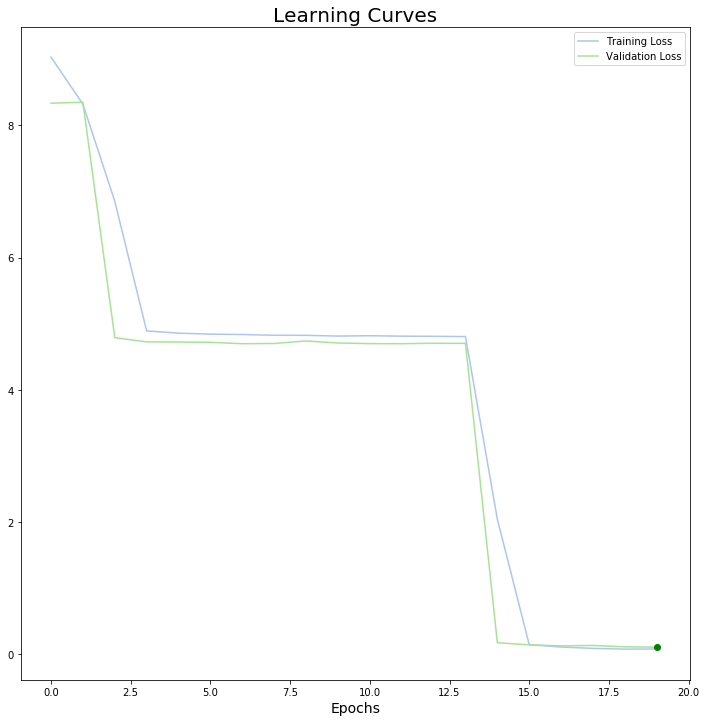

Max validation accuracy: 0.9676190543742407
Minimum validation loss: 0.10941571196807283


In [8]:
model = makeModel((28,28,1,))
model.summary()
hist1 = model.fit(mnist_train_x.reshape(mnist_train_x.shape[0],28,28,1), to_categorical(mnist_train_y,10),
                  batch_size=100,epochs=20,
                  validation_data=(mnist_validation_x,to_categorical(mnist_validation_y,10)))
learningCurves(hist1)

In [164]:
model2 = makeModel((32,32,3,))
model2.summary()
hist2 = model2.fit(svhn_train_x, to_categorical(svhn_train_y,10),batch_size=100,epochs=90,
                   validation_data=(svhn_validation_x,to_categorical(svhn_validation_y,10)))
learningCurves(hist2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 16, 16, 32)        9248      
_________________________________________________________________
global_max_pooling2d_11 (Glo (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               3300      
_________________________________________________________________
output (Dense)               (None, 10)                1010      
Total para

KeyboardInterrupt: 

In [141]:
def makeTranslator(inputSize,outputSize):
    inputs = Input(shape=inputSize,name="input")
    x      = Conv2D(2, (3, 3), padding='same', activation='relu')(inputs)
    out    = Conv2D(1, (5, 5), padding='valid', activation='relu')(x)

    model = Model(inputs=inputs, outputs=out)
    model.compile(optimizer='adam', loss='mse')
    
    return model

transMod = makeTranslator((32,32,3,),(28,28,1,))
transMod.summary()

histTrans = transMod.fit(svhn_x[0:42000],mnist_x,batch_size=1000,epochs=20,shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_188 (Conv2D)          (None, 32, 32, 2)         56        
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 28, 28, 1)         51        
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
42000/42000 [==============================] - 3s 76us/step - loss: 6944.5330
Epoch 2/20
42000/42000 [==============================] - 3s 70us/step - loss: 6455.2558
Epoch 3/20
42000/42000 [==============================] - 3s 68us/step - loss: 6353.4582
Epoch 4/20
42000/42000 [==============================] - 3s 68us/step - loss: 6262.7230
Epoch 5/20
42000/42000 [============================

KeyboardInterrupt: 

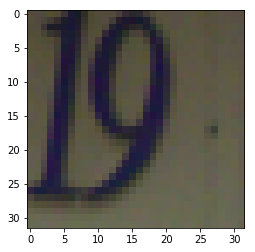

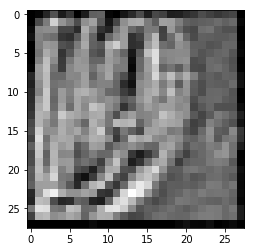

In [142]:
selIdx = 1
pred = transMod.predict(svhn_x[0:2])
plt.imshow(svhn_x[selIdx])
plt.show()
plt.imshow(pred[selIdx].reshape(28,28),cmap="gray")
plt.show()

In [96]:
pred[0].reshape(28,28).shape

(28, 28)